In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader,random_split
from torchvision import transforms, datasets, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [10]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        # Convolutional layers with batch norm
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) 
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2) 
        self.dropout = nn.Dropout(0.4)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 64 * 28 * 28)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x
    

In [34]:
class ClassificationModel(nn.Module):
    def __init__(self, image_size, num_classes):
        super(ClassificationModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(image_size[0], 16, kernel_size=3, stride=1, padding=1) # (224x224x3) -> (224x224x16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # (112x112x16) -> (112x112x32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # (56x56x32) -> (56x56x64)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2) # Halves the input dimensions
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 256) # 64 * 28 * 28 is the flattened feature map size after pooling
        self.fc2 = nn.Linear(256, 100) # 100 categories (classes)
        
    def forward(self, x):
        # Apply convolution layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the feature maps for the fully connected layer
        x = x.view(-1, 64 * 8 * 8)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [29]:
class ClassificationModel(nn.Module):
    def __init__(self, image_size, num_classes):
        super(ClassificationModel, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=image_size[0], out_channels=8, kernel_size=3, padding=1)  # Same padding
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, padding=1)  # Same padding
        self.flatten = nn.Flatten()
        
        # Calculate the flattened size after convolutions and pooling
        conv_output_size = self._get_conv_output_size(image_size)
        
        self.fc1 = nn.Linear(conv_output_size, num_classes)
    
    def forward(self, x):
        # Define forward pass
        x = F.relu(self.conv1(x))    # First Conv layer + ReLU
        x = self.pool(x)             # First Pooling
        x = F.relu(self.conv2(x))    # Second Conv layer + ReLU
        x = self.pool(x)             # Second Pooling
        x = self.flatten(x)          # Flatten the tensor
        x = F.softmax(self.fc1(x), dim=1)  # Output layer with softmax
        return x

    def _get_conv_output_size(self, image_size):
        # This function calculates the size of the flattened tensor after convolutions and pooling
        dummy_input = torch.zeros(1, *image_size)  # Create a dummy input tensor with the shape (batch_size, channels, height, width)
        output = self.pool(F.relu(self.conv1(dummy_input)))
        output = self.pool(F.relu(self.conv2(output)))
        return output.numel()  # Return the number of elements

In [35]:
image_size = (3, 64, 64)  # Example: 3 channels, 32x32 pixels
num_classes = 100

model = ClassificationModel(image_size, num_classes)
print(model)


ClassificationModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)


In [24]:
total_params = sum(p.numel() for p in model.parameters())
print("# parameters:", total_params)


# parameters: 205148


In [43]:
# from model import ClassificationModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 32
n_epochs = 50

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 224x224
    # Random augmentations
    transforms.RandomRotation(30),  # Randomly rotate images by 30 degrees
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),  # Random color jitter
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize with mean and std
])

path='train'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
model = ClassificationModel(image_size, num_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=20,eta_min=1e-9)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
    scheduler.step()

    
    
    # if early_stopper.early_stop(valid_loss):
    #     print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}") 
    #     break

AttributeError: 'Functional' object has no attribute 'parameters'

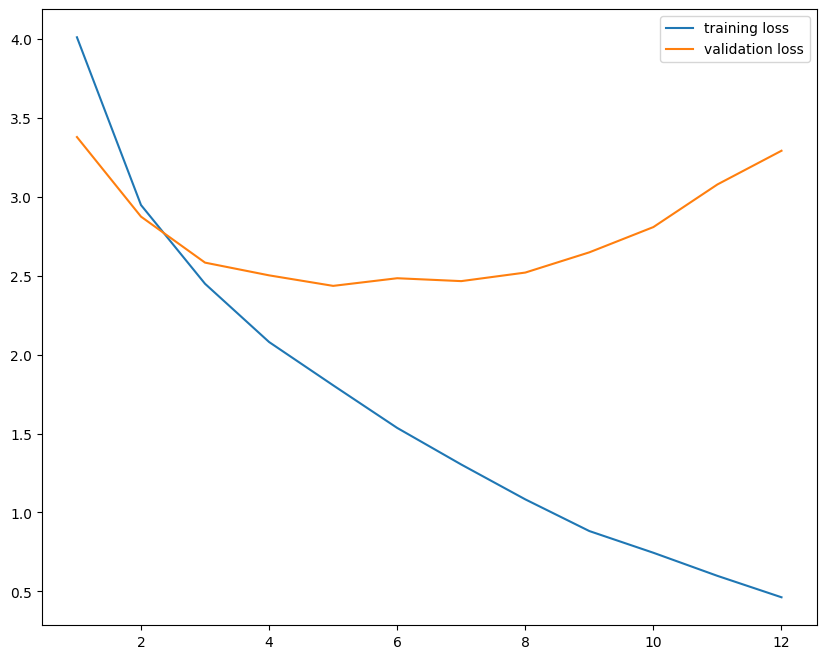

In [8]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()    

In [ ]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader, random_split
# from model import ClassificationModel

def train():
    # Hyperparameters
    batch_size = 32
    epochs = 40
    learning_rate = 0.001

    # Data transformations (resize, normalization)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load the dataset
    train_dataset = datasets.ImageFolder(root='train', transform=transform)

    # Split training set into train and validation sets
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_data, val_data = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = ClassificationModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

        # Validation after each epoch
        validate(model, val_loader)

def validate(model, val_loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

if __name__ == "__main__":
    train()


In [ ]:
mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/Images'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)